In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from torch.utils import data
import torch
import os
from from_scratch.dataset import Dataset, resize
from from_scratch.losses import ComputeLoss
from from_scratch.model import Yolo

In [33]:
# saving checkpoint
torch.save({
    'epoch': 60,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss / len(train_loader)
}, 'yolo_n_checkpoint.pth')

# Load the model
#model = Yolo(version='n')
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
#checkpoint = torch.load('yolo_n_checkpoint.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#print(f"Loaded model from checkpoint at epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

In [4]:
class SimpleLoss:
    def __init__(self, model, params=None):
        if hasattr(model, 'module'):
            model = model.module
        self.device = next(model.parameters()).device

    def __call__(self, outputs, targets):
        x1, x2, x3 = outputs
        y1, y2, y3 = targets
        # the loss is the sum of the cross-entropy loss for each pair of outputs and targets
        loss_fn = torch.nn.BCEWithLogitsLoss()
        loss = loss_fn(x1, y1) + loss_fn(x2, y2) + loss_fn(x3, y3)
        #loss = torch.nn.BCEWithLogitsLoss(x1, y1) + torch.nn.BCEWithLogitsLoss(x2, y2) + torch.nn.BCEWithLogitsLoss(x3, y3)
        # return a tensor with a single value, the loss
        if not isinstance(loss, torch.Tensor):
            loss = torch.tensor(loss, device=self.device)
        if loss.ndim == 0:  # if loss is a scalar
            loss = loss.unsqueeze(0)  # add a batch dimension
        elif loss.ndim == 1:  # if loss is a vector
            loss = loss.unsqueeze(0)  # add a batch dimension
        elif loss.ndim > 1:  # if loss is a matrix or higher
            loss = loss.mean(dim=0, keepdim=True)  # average over the first dimension

        return loss

In [4]:
dataset = Dataset('/home/davide/Desktop/change_detection/dataset', input_size=640)
train_loader = data.DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True)
print(f"Train_loader : {len(train_loader)} batches")

torch.manual_seed(42)

model = Yolo(version='n')
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")

criterion = SimpleLoss(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epochs = 10

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in train_loader:
        imgs = imgs.float()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch : {epoch + 1} | avg loss : {epoch_loss / len(train_loader)}")

Train_loader : 4 batches
2.637276 million parameters
Epoch : 1 | avg loss : 2.010443844800467
Epoch : 2 | avg loss : 1.740228753622708
Epoch : 3 | avg loss : 1.5988311395497923
Epoch : 4 | avg loss : 1.5204710103930337
Epoch : 5 | avg loss : 1.4929673498257645
Epoch : 6 | avg loss : 1.407604665373517
Epoch : 7 | avg loss : 1.3476153239442197
Epoch : 8 | avg loss : 1.2898225078207874
Epoch : 9 | avg loss : 1.2347499096992354
Epoch : 10 | avg loss : 1.1805702880047304


In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 3

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in train_loader:
        imgs = imgs.float()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch : {epoch + 1 + 58} | avg loss : {epoch_loss / len(train_loader)}")

Epoch : 59 | avg loss : 0.03565431793245793
Epoch : 60 | avg loss : 0.03333491923152676
Epoch : 61 | avg loss : 0.032065948200578044


In [12]:
test_dataset = Dataset('/home/davide/Desktop/change_detection/1_im_ds', input_size=640)
test_train_loader = data.DataLoader(test_dataset, batch_size=32, num_workers=0, pin_memory=True)
im, t = next(iter(test_train_loader))

In [31]:
out = model(im.float())
out = torch.sigmoid(out[2][0][1].cpu().detach()).numpy()
out[out < 0.5] = 0
out[out >= 0.5] = 1

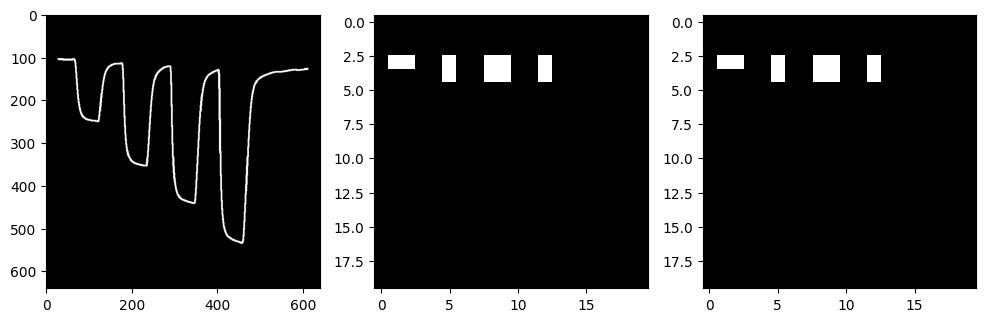

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(im[0][0].cpu().detach().numpy(), cmap='gray')
axs[1].imshow(t[2][0][1].cpu().detach().numpy(), cmap='gray')
axs[2].imshow(out, cmap='gray')